<a href="https://colab.research.google.com/github/samuramirez/cellmigration/blob/master/GetPCAComponentsAndPerformAnalysis_allOneTreatment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import auth
#This allows SDK to see and edit Google Drive files
#SDK is required to interact with GCP
auth.authenticate_user()

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la
import pandas as pd
import ntpath
import os
import re
from skimage.io import imread, imsave, imshow
import seaborn as sns

sns.set_theme(style="whitegrid")

!mkdir figures

In [4]:
#gets rid of extra spaces and brackets when reading in columns from csv file read in with pandas
#column is the column of the read in csv file (in the form of a dataframe) that we wish to clean up

def fix_pandas_column(column):
  for count, row in enumerate(column):
    row = row.strip('[]')
    column[count] = [float(i) for i in row.split()]
  return column

In [5]:
#make a dictionary for each region that has a track for a movie as the key. 
#Two dictionaries are created: one for the movies (data from csv file from VAMPIRE) and one for the tracks (data from the shape2tracks notebook). 
#The keys match the data between the two

def dict_of_movies_tracks(region, region_csv, file_paths):
  movie_dict = {}
  track_dict = {}

  for maskspath in file_paths:
    folder_loc = ntpath.basename(maskspath)
    print(folder_loc)

    !gsutil cp gs://{maskspath}_tracks_shape.pkl ./
    with open('/content/' + folder_loc + '_tracks_shape.pkl', 'rb') as handle:
              tracksshape = pickle.load(handle, encoding='latin1')

    trackparams = []

    for i in range(len(tracksshape)):
      if tracksshape[i]['gel-region'].str.contains(region).any():
        trackparams.append(tracksshape[i])

    reg_mov_csv = region_csv.loc[region_csv['Filename'].str.contains(folder_loc + '_track')]

    for df in trackparams:
      trackid = int(df['track_id'].loc[0])
      movie_dict[folder_loc + '_track' + str(trackid)] = reg_mov_csv.loc[reg_mov_csv['Filename'].str.contains('_track' + str(trackid) + '_')]
      track_dict[folder_loc + '_track' + str(trackid)] = df

  return movie_dict, track_dict

In [6]:
#sorts the movie dataframes in the dictionary generated from dict_of_movies() by frame number (in ascending order)
#df_dict is the output from dict_of_movies()

def sort_moviedict(df_dict):
  for i in df_dict:
    df = df_dict[i]
    filenames = df['Filename']
    frames = []
    for name in filenames:
      frames.append(int(name.split('_t')[-1].strip('.TIF')))
    df['Frames'] = frames
    df.set_index('Frames', inplace=True)
    df.sort_index(inplace=True)

In [7]:
#makes a plot of the shape mode over time for each cell in each movie for the stiffness region of interest
#input is movie_dict, which is the output from dict_of_movies() function

def plot_of_shapemodes(movie_dict):
  for i in movie_dict:
    sm = movie_dict[i]['Shape mode']
    plt.plot(list(range(len(sm))), sm)
    plt.xlabel('time')
    plt.ylabel('shape mode')

In [8]:
#makes a plot of the specified principal component over time for each cell in each movie for the stiffness region of interest
#input is movie_dict, which is the output from dict_of_movies() function, and the principal component we wish to look at

def plot_of_PCovertime(movie_dict, pc_num):
  for i in movie_dict:
    pc = []
    scores = movie_dict[i]['Score from PCA']
    for arr in scores:
      pc.append(arr[pc_num-1])
    plt.plot(list(range(len(pc))), pc)
    plt.xlabel('time')
    plt.ylabel('PC{}'.format(pc_num))

In [9]:
#makes a list of principal components for specified region and list of principal components associated with a high abs-skew value
#input is region movie dictionary, region track dictionary, and what the threshold is for what is considered a high abs-skew value
#output is list of principal components associated with high absskew for pc1 and pc2 as well as lists for all pc1 and pc2 for that region

def get_high_absskew_pc(region_movies,region_tracks,high_val,pc_n1,pc_n2):
  absskew_pcnum1 = []
  absskew_pcnum2 = []
  absskew_val = []
  pcnum1 = []
  pcnum2 = []
  for i in region_movies:
    for j in range(1,len(region_movies[i])+1):
      if region_tracks[i]['abs-skew'].loc[j-1] >= high_val:
        absskew_val.append(region_tracks[i]['abs-skew'].loc[j-1])
        absskew_pcnum1.append(region_movies[i]['Score from PCA'].loc[j][pc_n1-1])
        absskew_pcnum2.append(region_movies[i]['Score from PCA'].loc[j][pc_n2-1])

      pcnum1.append(region_movies[i]['Score from PCA'].loc[j][pc_n1-1])
      pcnum2.append(region_movies[i]['Score from PCA'].loc[j][pc_n2-1])

  return absskew_pcnum1,absskew_pcnum2,pcnum1,pcnum2,absskew_val

In [10]:
treatment_path = 'cellmbucket/analysis/controls_paths_11222021.txt' #@param {type:"string"}

#read treatment locations file
!gsutil cp gs://{treatment_path} ./
treatment_file = ntpath.basename(treatment_path)
treatment_obj = open(treatment_file, "r")
treatment_locs = treatment_obj.readlines()

Copying gs://cellmbucket/analysis/controls_paths_11222021.txt...
/ [1 files][  1.1 KiB/  1.1 KiB]                                                
Operation completed over 1 objects/1.1 KiB.                                      


In [11]:
#get all files full paths. Some data has the same name but is stored in different folder
file_paths = []
for i in range(1,len(treatment_locs)):
  if len(treatment_locs[i].strip("\n")) > 0: #if line contains data
    file_paths.append(treatment_locs[i].strip("\n"))

In [12]:
#@markdown path to folder where VAMPIRE analysis output is saved for a model
vam_mod_analysis_folder = "cellmbucket/VAMPIRE_analysis/all_controls/11222021/50Coords10PC10ShapeModes_4Regions_allcontrols" #@param {type:"string"}

In [13]:
vam_mod = vam_mod_analysis_folder + "/" + ntpath.basename(vam_mod_analysis_folder)+ ".pickle"

!gsutil cp gs://{vam_mod} ./

with open('/content/' + ntpath.basename(vam_mod), 'rb') as handle:
            model = pickle.load(handle, encoding='latin1')

Copying gs://cellmbucket/VAMPIRE_analysis/all_controls/11222021/50Coords10PC10ShapeModes_4Regions_allcontrols/50Coords10PC10ShapeModes_4Regions_allcontrols.pickle...
/ [1 files][ 82.5 KiB/ 82.5 KiB]                                                
Operation completed over 1 objects/82.5 KiB.                                     


In [14]:
!gsutil cp gs://{vam_mod_analysis_folder}"/VAMPIRE datasheet stiff.csv" ./

stiff_csv = pd.read_csv("/content/VAMPIRE datasheet stiff.csv")

Copying gs://cellmbucket/VAMPIRE_analysis/all_controls/11222021/50Coords10PC10ShapeModes_4Regions_allcontrols/VAMPIRE datasheet stiff.csv...
/ [1 files][ 14.2 MiB/ 14.2 MiB]                                                
Operation completed over 1 objects/14.2 MiB.                                     


In [15]:
!gsutil cp gs://{vam_mod_analysis_folder}"/VAMPIRE datasheet gradient1.csv" ./

gradient1_csv = pd.read_csv("/content/VAMPIRE datasheet gradient1.csv")

Copying gs://cellmbucket/VAMPIRE_analysis/all_controls/11222021/50Coords10PC10ShapeModes_4Regions_allcontrols/VAMPIRE datasheet gradient1.csv...
/ [1 files][ 14.2 MiB/ 14.2 MiB]                                                
Operation completed over 1 objects/14.2 MiB.                                     


In [16]:
!gsutil cp gs://{vam_mod_analysis_folder}"/VAMPIRE datasheet gradient2.csv" ./

gradient2_csv = pd.read_csv("/content/VAMPIRE datasheet gradient2.csv")

Copying gs://cellmbucket/VAMPIRE_analysis/all_controls/11222021/50Coords10PC10ShapeModes_4Regions_allcontrols/VAMPIRE datasheet gradient2.csv...
/ [1 files][ 13.7 MiB/ 13.7 MiB]                                                
Operation completed over 1 objects/13.7 MiB.                                     


In [17]:
!gsutil cp gs://{vam_mod_analysis_folder}"/VAMPIRE datasheet soft.csv" ./

soft_csv = pd.read_csv("/content/VAMPIRE datasheet soft.csv")

Copying gs://cellmbucket/VAMPIRE_analysis/all_controls/11222021/50Coords10PC10ShapeModes_4Regions_allcontrols/VAMPIRE datasheet soft.csv...
/ [1 files][  9.3 MiB/  9.3 MiB]                                                
Operation completed over 1 objects/9.3 MiB.                                      


In [18]:
model

{'C': array([[ 9.74143384e-02, -6.00358359e-02, -1.47764444e-01,
          1.53050879e-01, -8.77854423e-02,  2.03468913e-01,
         -1.35525471e-03,  3.14153159e-01, -8.69432448e-03,
          4.19658789e-01],
        [-5.54816374e-03, -4.25701220e-01,  2.44990004e-01,
         -9.24998994e-02,  2.02905383e-02, -2.40369787e-01,
          9.47257542e-03,  1.74042240e-01,  1.37175203e-01,
         -4.62820556e-02],
        [ 1.92105021e-01,  1.05815177e-01, -2.71617386e-02,
         -3.20256835e-01, -1.55630524e-01,  7.18084522e-02,
         -2.55151329e-01, -7.71100195e-02,  2.32227910e-01,
         -2.04015133e-01],
        [ 5.88943541e-01,  5.47842660e-02,  4.16434144e-02,
         -1.47323392e-02, -2.26926139e-03,  1.39382263e-02,
         -3.22528632e-02, -1.99579039e-01,  1.44040037e-02,
          2.97151458e-01],
        [ 1.76843539e-01, -9.92541803e-02,  5.50398219e-02,
         -1.74277029e-01,  1.79378523e-01,  2.34732774e-01,
          2.75445365e-01, -7.92438803e-02, -2.7

In [19]:
eigenval = model['eigenvalues']

In [20]:
eigenvecs = model['pc']

In [21]:
np.shape(model['bdrn'])

(2, 50)

In [22]:
np.shape(eigenvecs)

(100, 100)

In [23]:
percents = (eigenval/sum(eigenval))*100
print(percents)

[3.36659192e+01 1.56040944e+01 1.43510302e+01 4.94995305e+00
 4.54018717e+00 4.24278949e+00 4.02026624e+00 2.36478481e+00
 1.81699499e+00 1.57277482e+00 1.47028211e+00 1.08730623e+00
 9.42618920e-01 9.07973896e-01 7.07574763e-01 5.84309590e-01
 5.46523183e-01 5.19469952e-01 4.96115652e-01 3.97087060e-01
 3.39814106e-01 3.37716487e-01 3.33124628e-01 3.17554396e-01
 3.03268509e-01 2.26912822e-01 2.21619130e-01 2.14121544e-01
 2.12540373e-01 1.71800209e-01 1.60409017e-01 1.45575699e-01
 1.45319597e-01 1.19042235e-01 1.17117346e-01 1.04122261e-01
 1.02735216e-01 8.93575076e-02 8.85239712e-02 7.70083386e-02
 7.61910644e-02 6.63513851e-02 6.59781833e-02 5.90152188e-02
 5.70984656e-02 5.12135696e-02 5.04875444e-02 4.44226258e-02
 4.40295834e-02 4.04282756e-02 3.92173907e-02 3.57682403e-02
 3.48857528e-02 3.22272133e-02 3.17197713e-02 2.93564953e-02
 2.87660369e-02 2.61981793e-02 2.55444369e-02 2.44388846e-02
 2.39194293e-02 2.19295903e-02 2.16932745e-02 2.09348918e-02
 2.06219820e-02 1.861008

In [24]:
np.sum(percents[0:10])

87.12879432174255

In [25]:
np.sum(percents[0:20])

94.78805567225074

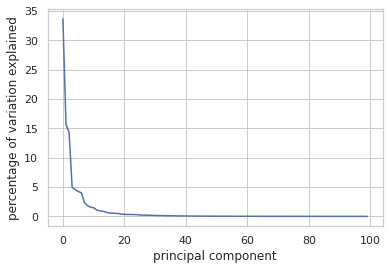

In [26]:
plt.plot(list(range(0,len(eigenval))), percents)
plt.xlabel('principal component')
plt.ylabel('percentage of variation explained')

plt.savefig('/content/figures/eigenval_weights.eps')

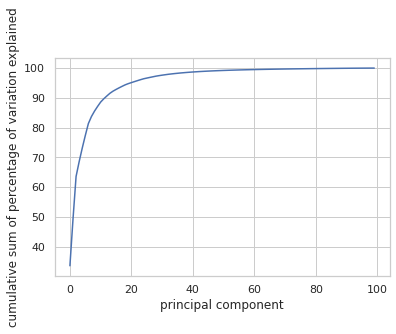

In [27]:
plt.plot(list(range(0,len(eigenval))), np.cumsum(percents))
plt.xlabel('principal component')
plt.ylabel('cumulative sum of percentage of variation explained')

plt.savefig('/content/figures/cumsum_eigenval.eps')

In [28]:
#get boundary coordinates for each region

stiff_bdpts = stiff_csv['Boundary coordinates'].to_numpy()
stiff_bdpts = fix_pandas_column(stiff_bdpts)

gradient1_bdpts = gradient1_csv['Boundary coordinates'].to_numpy()
gradient1_bdpts = fix_pandas_column(gradient1_bdpts)

gradient2_bdpts = gradient2_csv['Boundary coordinates'].to_numpy()
gradient2_bdpts = fix_pandas_column(gradient2_bdpts)

soft_bdpts = soft_csv['Boundary coordinates'].to_numpy()
soft_bdpts = fix_pandas_column(soft_bdpts)

In [29]:
#get pca scores for each region

stiff_scores = stiff_csv['Score from PCA'].to_numpy()
stiff_scores = fix_pandas_column(stiff_scores)

gradient1_scores = gradient1_csv['Score from PCA'].to_numpy()
gradient1_scores = fix_pandas_column(gradient1_scores)

gradient2_scores = gradient2_csv['Score from PCA'].to_numpy()
gradient2_scores = fix_pandas_column(gradient2_scores)

soft_scores = soft_csv['Score from PCA'].to_numpy()
soft_scores = fix_pandas_column(soft_scores)

##Stiff region

In [30]:
stiff_movies, stiff_tracks = dict_of_movies_tracks('stiff', stiff_csv, file_paths)

sort_moviedict(stiff_movies)

06032020-JR20-control
Copying gs://cellmbucket/analysis_042221/06032020-JR20-control_tracks_shape.pkl...
/ [1 files][500.4 KiB/500.4 KiB]                                                
Operation completed over 1 objects/500.4 KiB.                                    
03122021-JR20P14-control-sample5
Copying gs://cellmbucket/analysis_pri_050521/03122021-JR20P14-control-sample5_tracks_shape.pkl...
/ [1 files][460.3 KiB/460.3 KiB]                                                
Operation completed over 1 objects/460.3 KiB.                                    
03122021-JR20P14-control
Copying gs://cellmbucket/analysis_pri_050521/03122021-JR20P14-control_tracks_shape.pkl...
/ [1 files][756.9 KiB/756.9 KiB]                                                
Operation completed over 1 objects/756.9 KiB.                                    
031521_control_sample3
Copying gs://cellmbucket/analysis_sam_042821/031521_control_sample3_tracks_shape.pkl...
/ [1 files][231.2 KiB/231.2 KiB]                 

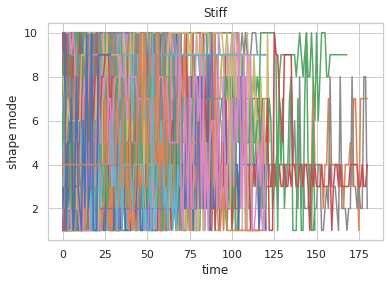

In [31]:
plot_of_shapemodes(stiff_movies)
plt.title('Stiff')

plt.savefig('/content/figures/stiff_sm_overtime.eps')

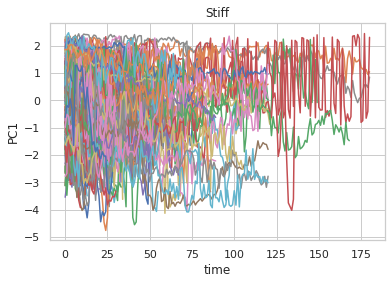

In [32]:
plot_of_PCovertime(stiff_movies, 1)
plt.title('Stiff')

plt.savefig('/content/figures/stiff_pc1_overtime.eps')

##Gradient1 region

In [33]:
gradient1_movies, gradient1_tracks = dict_of_movies_tracks('gradient1', gradient1_csv, file_paths)

sort_moviedict(gradient1_movies)

06032020-JR20-control
Copying gs://cellmbucket/analysis_042221/06032020-JR20-control_tracks_shape.pkl...
/ [1 files][500.4 KiB/500.4 KiB]                                                
Operation completed over 1 objects/500.4 KiB.                                    
03122021-JR20P14-control-sample5
Copying gs://cellmbucket/analysis_pri_050521/03122021-JR20P14-control-sample5_tracks_shape.pkl...
/ [1 files][460.3 KiB/460.3 KiB]                                                
Operation completed over 1 objects/460.3 KiB.                                    
03122021-JR20P14-control
Copying gs://cellmbucket/analysis_pri_050521/03122021-JR20P14-control_tracks_shape.pkl...
/ [1 files][756.9 KiB/756.9 KiB]                                                
Operation completed over 1 objects/756.9 KiB.                                    
031521_control_sample3
Copying gs://cellmbucket/analysis_sam_042821/031521_control_sample3_tracks_shape.pkl...
/ [1 files][231.2 KiB/231.2 KiB]                 

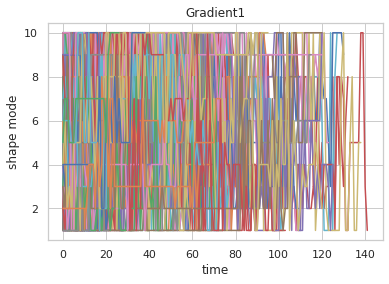

In [34]:
plot_of_shapemodes(gradient1_movies)
plt.title('Gradient1')

plt.savefig('/content/figures/grad1_sm_overtime.eps')

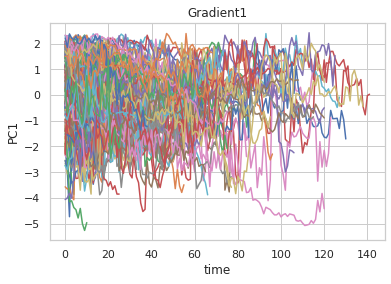

In [35]:
plot_of_PCovertime(gradient1_movies, 1)
plt.title('Gradient1')

plt.savefig('/content/figures/grad1_pc1_overtime.eps')

##Gradient2 region

In [36]:
gradient2_movies, gradient2_tracks = dict_of_movies_tracks('gradient2', gradient2_csv, file_paths)

sort_moviedict(gradient2_movies)

06032020-JR20-control
Copying gs://cellmbucket/analysis_042221/06032020-JR20-control_tracks_shape.pkl...
/ [1 files][500.4 KiB/500.4 KiB]                                                
Operation completed over 1 objects/500.4 KiB.                                    
03122021-JR20P14-control-sample5
Copying gs://cellmbucket/analysis_pri_050521/03122021-JR20P14-control-sample5_tracks_shape.pkl...
/ [1 files][460.3 KiB/460.3 KiB]                                                
Operation completed over 1 objects/460.3 KiB.                                    
03122021-JR20P14-control
Copying gs://cellmbucket/analysis_pri_050521/03122021-JR20P14-control_tracks_shape.pkl...
/ [1 files][756.9 KiB/756.9 KiB]                                                
Operation completed over 1 objects/756.9 KiB.                                    
031521_control_sample3
Copying gs://cellmbucket/analysis_sam_042821/031521_control_sample3_tracks_shape.pkl...
/ [1 files][231.2 KiB/231.2 KiB]                 

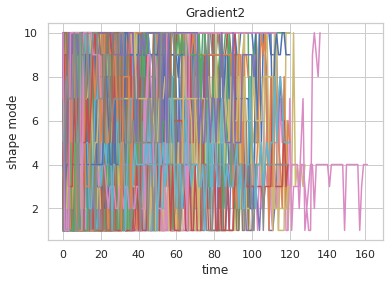

In [37]:
plot_of_shapemodes(gradient2_movies)
plt.title('Gradient2')

plt.savefig('/content/figures/grad2_sm_overtime.eps')

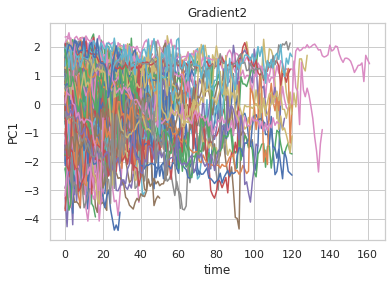

In [38]:
plot_of_PCovertime(gradient2_movies, 1)
plt.title('Gradient2')

plt.savefig('/content/figures/grad2_pc1_overtime.eps')

##Soft region

In [39]:
soft_movies, soft_tracks = dict_of_movies_tracks('soft', soft_csv, file_paths)

sort_moviedict(soft_movies)

06032020-JR20-control
Copying gs://cellmbucket/analysis_042221/06032020-JR20-control_tracks_shape.pkl...
/ [1 files][500.4 KiB/500.4 KiB]                                                
Operation completed over 1 objects/500.4 KiB.                                    
03122021-JR20P14-control-sample5
Copying gs://cellmbucket/analysis_pri_050521/03122021-JR20P14-control-sample5_tracks_shape.pkl...
/ [1 files][460.3 KiB/460.3 KiB]                                                
Operation completed over 1 objects/460.3 KiB.                                    
03122021-JR20P14-control
Copying gs://cellmbucket/analysis_pri_050521/03122021-JR20P14-control_tracks_shape.pkl...
/ [1 files][756.9 KiB/756.9 KiB]                                                
Operation completed over 1 objects/756.9 KiB.                                    
031521_control_sample3
Copying gs://cellmbucket/analysis_sam_042821/031521_control_sample3_tracks_shape.pkl...
/ [1 files][231.2 KiB/231.2 KiB]                 

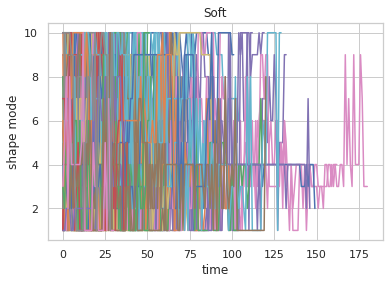

In [40]:
plot_of_shapemodes(soft_movies)
plt.title('Soft')

plt.savefig('/content/figures/soft_sm_overtime.eps')

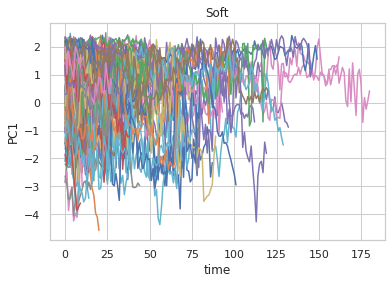

In [41]:
plot_of_PCovertime(soft_movies, 1)
plt.title('Soft')

plt.savefig('/content/figures/soft_pc1_overtime.eps')

##PC plots by region

##PC2 vs PC1

In [42]:
!mkdir figures/pc2vspc1

In [43]:
stiff_as_pc1, stiff_as_pc2, stiff_pc1, stiff_pc2, stiff_absskew_val = get_high_absskew_pc(stiff_movies, stiff_tracks, 0.3, 1, 2)
grad1_as_pc1, grad1_as_pc2, grad1_pc1, grad1_pc2, grad1_absskew_val = get_high_absskew_pc(gradient1_movies, gradient1_tracks, 0.3, 1, 2)
grad2_as_pc1, grad2_as_pc2, grad2_pc1, grad2_pc2, grad2_absskew_val = get_high_absskew_pc(gradient2_movies, gradient2_tracks, 0.3, 1, 2)
soft_as_pc1, soft_as_pc2, soft_pc1, soft_pc2, soft_absskew_val = get_high_absskew_pc(soft_movies, soft_tracks, 0.3, 1, 2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


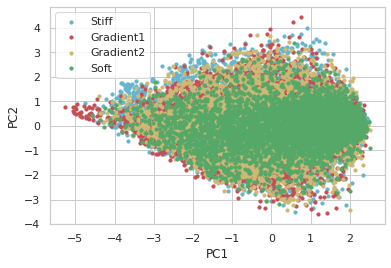

In [44]:
plt.scatter(stiff_pc1,stiff_pc2, c='c', label='Stiff', s=10)
plt.scatter(grad1_pc1,grad1_pc2, c='r', label='Gradient1', s=10)
plt.scatter(grad2_pc1,grad2_pc2, c='y', label='Gradient2', s=10)
plt.scatter(soft_pc1,soft_pc2, c='g', label='Soft', s=10)

plt.legend()

plt.xlabel("PC1")
plt.ylabel("PC2")

plt.savefig('/content/figures/pc2vspc1/all_regions.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


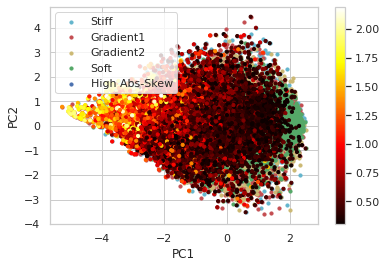

In [45]:
plt.scatter(stiff_pc1,stiff_pc2, c='c', label='Stiff', s=10)
plt.scatter(grad1_pc1,grad1_pc2, c='r', label='Gradient1', s=10)
plt.scatter(grad2_pc1,grad2_pc2, c='y', label='Gradient2', s=10)
plt.scatter(soft_pc1,soft_pc2, c='g', label='Soft', s=10)

plt.scatter(stiff_as_pc1,stiff_as_pc2, c=stiff_absskew_val, cmap='hot', label='High Abs-Skew', s=10)
plt.scatter(grad1_as_pc1,grad1_as_pc2, c=grad1_absskew_val, cmap='hot', s=10)
plt.scatter(grad2_as_pc1,grad2_as_pc2, c=grad2_absskew_val, cmap='hot', s=10)
plt.scatter(soft_as_pc1,soft_as_pc2, c=soft_absskew_val, cmap='hot', s=10)

plt.legend()
plt.colorbar()

plt.xlabel("PC1")
plt.ylabel("PC2")

plt.savefig('/content/figures/pc2vspc1/all_regions_absskew.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


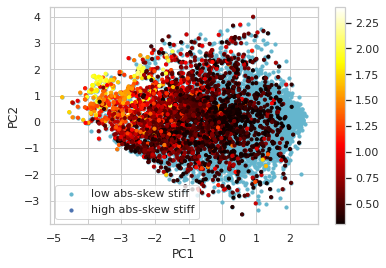

In [46]:
plt.scatter(stiff_pc1,stiff_pc2, c='c',label='low abs-skew stiff', s=10)
plt.scatter(stiff_as_pc1,stiff_as_pc2, c=stiff_absskew_val, cmap='hot',label='high abs-skew stiff', s=10)

plt.xlabel('PC1')
plt.ylabel('PC2')

plt.legend()
plt.colorbar()

plt.savefig('/content/figures/pc2vspc1/stiff_absskew.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


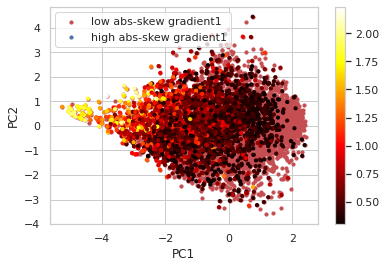

In [47]:
plt.scatter(grad1_pc1,grad1_pc2, c='r', label='low abs-skew gradient1', s=10)
plt.scatter(grad1_as_pc1,grad1_as_pc2, c=grad1_absskew_val, cmap='hot', label='high abs-skew gradient1', s=10)

plt.xlabel('PC1')
plt.ylabel('PC2')

plt.legend()
plt.colorbar()

plt.savefig('/content/figures/pc2vspc1/grad1_absskew.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


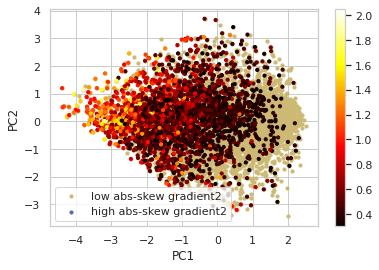

In [48]:
plt.scatter(grad2_pc1,grad2_pc2, c='y', label='low abs-skew gradient2', s=10)
plt.scatter(grad2_as_pc1,grad2_as_pc2, c=grad2_absskew_val, cmap='hot', label='high abs-skew gradient2', s=10)

plt.xlabel('PC1')
plt.ylabel('PC2')

plt.legend()
plt.colorbar()

plt.savefig('/content/figures/pc2vspc1/grad2_absskew.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


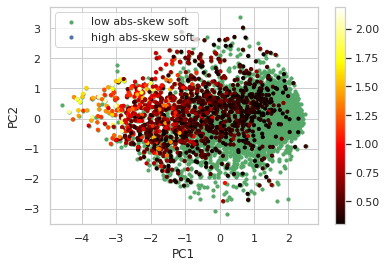

In [49]:
plt.scatter(soft_pc1,soft_pc2, c='g', label='low abs-skew soft', s=10)
plt.scatter(soft_as_pc1,soft_as_pc2, c=soft_absskew_val, cmap='hot', label='high abs-skew soft', s=10)

plt.xlabel('PC1')
plt.ylabel('PC2')

plt.legend()
plt.colorbar()

plt.savefig('/content/figures/pc2vspc1/soft_absskew.eps')

##PC3 vs PC2

In [50]:
!mkdir figures/pc3vspc2

In [51]:
stiff_as_pc2, stiff_as_pc3, stiff_pc2, stiff_pc3, stiff_absskew_val = get_high_absskew_pc(stiff_movies, stiff_tracks, 0.3, 2, 3)
grad1_as_pc2, grad1_as_pc3, grad1_pc2, grad1_pc3, grad1_absskew_val = get_high_absskew_pc(gradient1_movies, gradient1_tracks, 0.3, 2, 3)
grad2_as_pc2, grad2_as_pc3, grad2_pc2, grad2_pc3, grad2_absskew_val = get_high_absskew_pc(gradient2_movies, gradient2_tracks, 0.3, 2, 3)
soft_as_pc2, soft_as_pc3, soft_pc2, soft_pc3, soft_absskew_val = get_high_absskew_pc(soft_movies, soft_tracks, 0.3, 2, 3)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


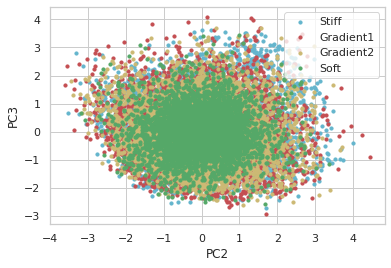

In [52]:
plt.scatter(stiff_pc2,stiff_pc3, c='c', label='Stiff', s=10)
plt.scatter(grad1_pc2,grad1_pc3, c='r', label='Gradient1', s=10)
plt.scatter(grad2_pc2,grad2_pc3, c='y', label='Gradient2', s=10)
plt.scatter(soft_pc2,soft_pc3, c='g', label='Soft', s=10)

plt.legend()

plt.xlabel("PC2")
plt.ylabel("PC3")

plt.savefig('/content/figures/pc3vspc2/all_regions.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


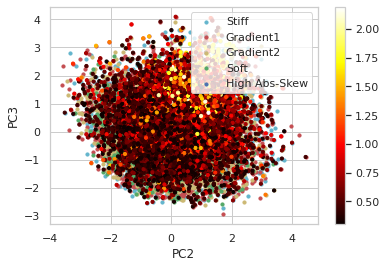

In [53]:
plt.scatter(stiff_pc2,stiff_pc3, c='c', label='Stiff', s=10)
plt.scatter(grad1_pc2,grad1_pc3, c='r', label='Gradient1', s=10)
plt.scatter(grad2_pc2,grad2_pc3, c='y', label='Gradient2', s=10)
plt.scatter(soft_pc2,soft_pc3, c='g', label='Soft', s=10)

plt.scatter(stiff_as_pc2,stiff_as_pc3, c=stiff_absskew_val, cmap='hot', label='High Abs-Skew', s=10)
plt.scatter(grad1_as_pc2,grad1_as_pc3, c=grad1_absskew_val, cmap='hot', s=10)
plt.scatter(grad2_as_pc2,grad2_as_pc3, c=grad2_absskew_val, cmap='hot', s=10)
plt.scatter(soft_as_pc2,soft_as_pc3, c=soft_absskew_val, cmap='hot', s=10)

plt.legend()
plt.colorbar()

plt.xlabel("PC2")
plt.ylabel("PC3")

plt.savefig('/content/figures/pc3vspc2/all_regions_absskew.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


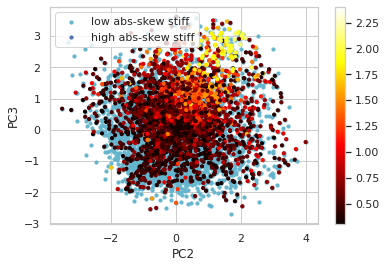

In [54]:
plt.scatter(stiff_pc2,stiff_pc3, c='c',label='low abs-skew stiff', s=10)
plt.scatter(stiff_as_pc2,stiff_as_pc3, c=stiff_absskew_val, cmap='hot', label='high abs-skew stiff', s=10)

plt.xlabel('PC2')
plt.ylabel('PC3')

plt.legend()
plt.colorbar()

plt.savefig('/content/figures/pc3vspc2/stiff_absskew.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


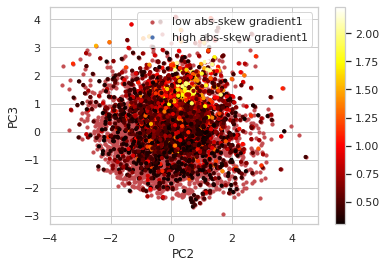

In [55]:
plt.scatter(grad1_pc2,grad1_pc3, c='r', label='low abs-skew gradient1', s=10)
plt.scatter(grad1_as_pc2,grad1_as_pc3, c=grad1_absskew_val, cmap='hot', label='high abs-skew gradient1', s=10)

plt.xlabel('PC2')
plt.ylabel('PC3')

plt.legend()
plt.colorbar()

plt.savefig('/content/figures/pc3vspc2/grad1_absskew.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


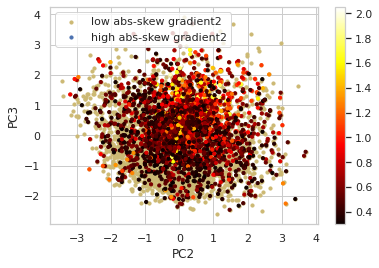

In [56]:
plt.scatter(grad2_pc2,grad2_pc3, c='y', label='low abs-skew gradient2', s=10)
plt.scatter(grad2_as_pc2,grad2_as_pc3, c=grad2_absskew_val, cmap='hot', label='high abs-skew gradient2', s=10)

plt.xlabel('PC2')
plt.ylabel('PC3')

plt.legend()
plt.colorbar()

plt.savefig('/content/figures/pc3vspc2/grad2_absskew.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


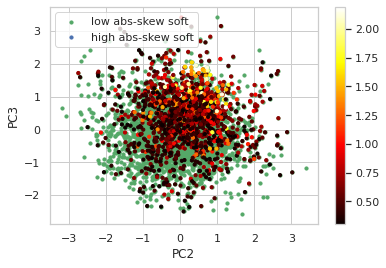

In [57]:
plt.scatter(soft_pc2,soft_pc3, c='g', label='low abs-skew soft', s=10)
plt.scatter(soft_as_pc2,soft_as_pc3, c=soft_absskew_val, cmap='hot', label='high abs-skew soft', s=10)

plt.xlabel('PC2')
plt.ylabel('PC3')

plt.legend()
plt.colorbar()

plt.savefig('/content/figures/pc3vspc2/soft_absskew.eps')

##PC4 vs PC3

In [58]:
!mkdir figures/pc4vspc3

In [59]:
stiff_as_pc3, stiff_as_pc4, stiff_pc3, stiff_pc4, stiff_absskew_val = get_high_absskew_pc(stiff_movies, stiff_tracks, 0.3, 3, 4)
grad1_as_pc3, grad1_as_pc4, grad1_pc3, grad1_pc4, grad1_absskew_val = get_high_absskew_pc(gradient1_movies, gradient1_tracks, 0.3, 3, 4)
grad2_as_pc3, grad2_as_pc4, grad2_pc3, grad2_pc4, grad2_absskew_val = get_high_absskew_pc(gradient2_movies, gradient2_tracks, 0.3, 3, 4)
soft_as_pc3, soft_as_pc4, soft_pc3, soft_pc4, soft_absskew_val = get_high_absskew_pc(soft_movies, soft_tracks, 0.3, 3, 4)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


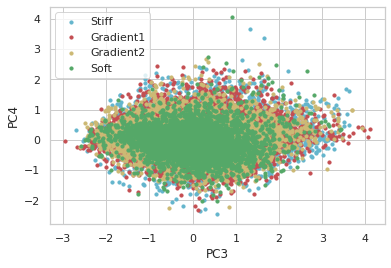

In [60]:
plt.scatter(stiff_pc3,stiff_pc4, c='c', label='Stiff', s=10)
plt.scatter(grad1_pc3,grad1_pc4, c='r', label='Gradient1', s=10)
plt.scatter(grad2_pc3,grad2_pc4, c='y', label='Gradient2', s=10)
plt.scatter(soft_pc3,soft_pc4, c='g', label='Soft', s=10)

plt.legend()

plt.xlabel("PC3")
plt.ylabel("PC4")

plt.savefig('/content/figures/pc4vspc3/all_regions.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


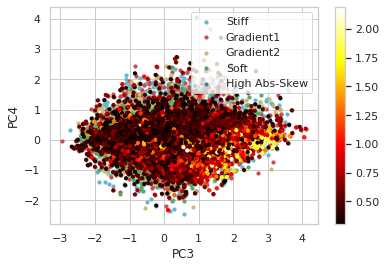

In [61]:
plt.scatter(stiff_pc3,stiff_pc4, c='c', label='Stiff', s=10)
plt.scatter(grad1_pc3,grad1_pc4, c='r', label='Gradient1', s=10)
plt.scatter(grad2_pc3,grad2_pc4, c='y', label='Gradient2', s=10)
plt.scatter(soft_pc3,soft_pc4, c='g', label='Soft', s=10)

plt.scatter(stiff_as_pc3,stiff_as_pc4, c=stiff_absskew_val, cmap='hot', label='High Abs-Skew', s=10)
plt.scatter(grad1_as_pc3,grad1_as_pc4, c=grad1_absskew_val, cmap='hot', s=10)
plt.scatter(grad2_as_pc3,grad2_as_pc4, c=grad2_absskew_val, cmap='hot', s=10)
plt.scatter(soft_as_pc3,soft_as_pc4, c=soft_absskew_val, cmap='hot', s=10)

plt.legend()
plt.colorbar()

plt.xlabel("PC3")
plt.ylabel("PC4")

plt.savefig('/content/figures/pc4vspc3/all_regions_absskew.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


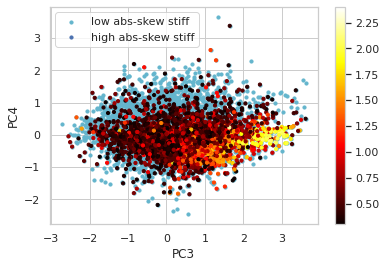

In [62]:
plt.scatter(stiff_pc3,stiff_pc4, c='c', label='low abs-skew stiff', s=10)
plt.scatter(stiff_as_pc3,stiff_as_pc4, c=stiff_absskew_val, cmap='hot', label='high abs-skew stiff', s=10)

plt.xlabel('PC3')
plt.ylabel('PC4')

plt.colorbar()
plt.legend()

plt.savefig('/content/figures/pc4vspc3/stiff_absskew.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


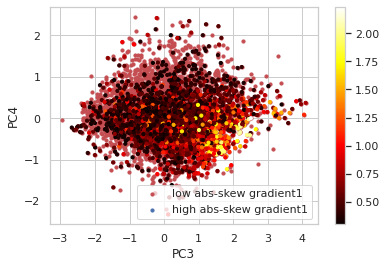

In [63]:
plt.scatter(grad1_pc3,grad1_pc4, c='r', label='low abs-skew gradient1', s=10)
plt.scatter(grad1_as_pc3,grad1_as_pc4, c=grad1_absskew_val, cmap='hot', label='high abs-skew gradient1', s=10)

plt.xlabel('PC3')
plt.ylabel('PC4')

plt.colorbar()
plt.legend()

plt.savefig('/content/figures/pc4vspc3/grad1_absskew.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


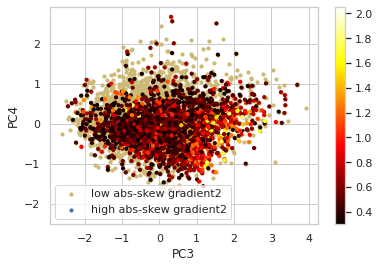

In [64]:
plt.scatter(grad2_pc3,grad2_pc4, c='y', label='low abs-skew gradient2', s=10)
plt.scatter(grad2_as_pc3,grad2_as_pc4, c=grad2_absskew_val, cmap='hot', label='high abs-skew gradient2', s=10)

plt.xlabel('PC3')
plt.ylabel('PC4')

plt.colorbar()
plt.legend()

plt.savefig('/content/figures/pc4vspc3/grad2_absskew.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


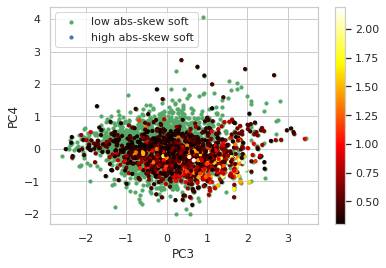

In [65]:
plt.scatter(soft_pc3,soft_pc4, c='g', label='low abs-skew soft', s=10)
plt.scatter(soft_as_pc3,soft_as_pc4, c=soft_absskew_val, cmap='hot', label='high abs-skew soft', s=10)

plt.xlabel('PC3')
plt.ylabel('PC4')

plt.colorbar()
plt.legend()

plt.savefig('/content/figures/pc4vspc3/soft_absskew.eps')

##Boxplots with PC

In [66]:
data_bp = {'stiff_pc1':stiff_pc1, 'gradient1_pc1':grad1_pc1, 'gradient2_pc1':grad2_pc1, 'soft_pc1': soft_pc1}

In [67]:
pc1_boxplot = pd.DataFrame({ key:pd.Series(value) for key, value in data_bp.items() })

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


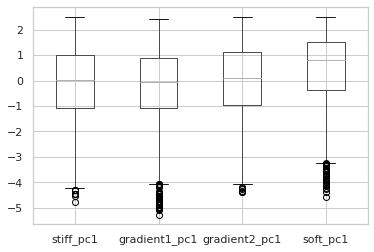

In [68]:
boxplot = pc1_boxplot.boxplot(column=['stiff_pc1', 'gradient1_pc1', 'gradient2_pc1', 'soft_pc1'])

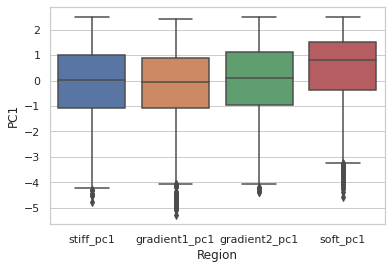

In [69]:
sns.boxplot(data=pc1_boxplot)
plt.xlabel("Region")
plt.ylabel("PC1")

plt.savefig('/content/figures/boxplot_pc1.eps')

In [70]:
!mkdir figures/histograms

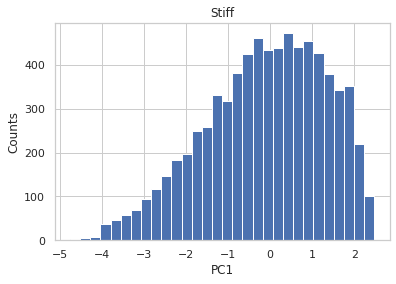

In [71]:
plt.hist(stiff_pc1, density=False, bins=30)
plt.title('Stiff')
plt.xlabel('PC1')
plt.ylabel('Counts')

plt.savefig('/content/figures/histograms/stiff_pc1.eps')

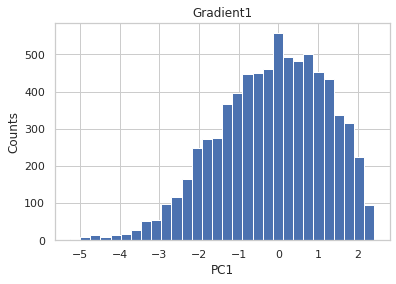

In [72]:
plt.hist(grad1_pc1, density=False, bins=30)
plt.title('Gradient1')
plt.xlabel('PC1')
plt.ylabel('Counts')

plt.savefig('/content/figures/histograms/grad1_pc1.eps')

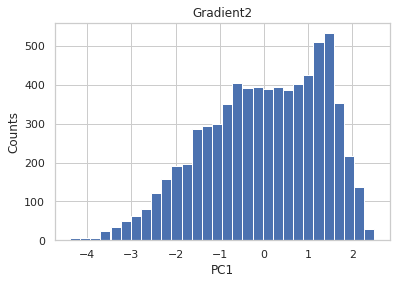

In [73]:
plt.hist(grad2_pc1, density=False, bins=30)
plt.title('Gradient2')
plt.xlabel('PC1')
plt.ylabel('Counts')

plt.savefig('/content/figures/histograms/grad2_pc1.eps')

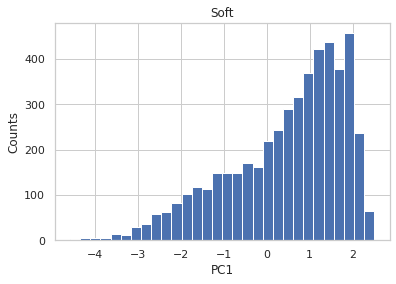

In [74]:
plt.hist(soft_pc1, density=False, bins=30)
plt.title('Soft')
plt.xlabel('PC1')
plt.ylabel('Counts')

plt.savefig('/content/figures/histograms/soft_pc1.eps')

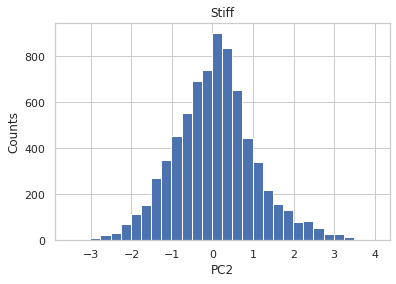

In [75]:
plt.hist(stiff_pc2, density=False, bins=30)
plt.title('Stiff')
plt.xlabel('PC2')
plt.ylabel('Counts')

plt.savefig('/content/figures/histograms/stiff_pc2.eps')

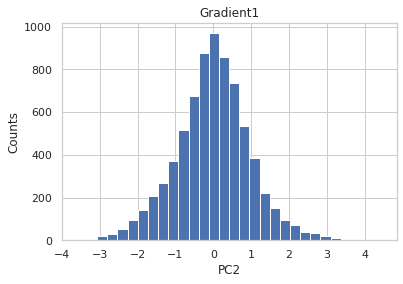

In [76]:
plt.hist(grad1_pc2, density=False, bins=30)
plt.title('Gradient1')
plt.xlabel('PC2')
plt.ylabel('Counts')

plt.savefig('/content/figures/histograms/grad1_pc2.eps')

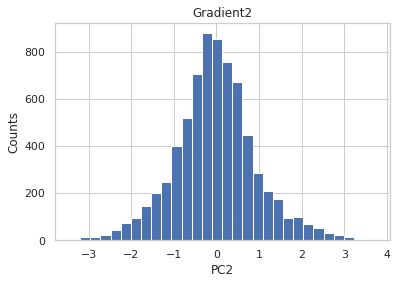

In [77]:
plt.hist(grad2_pc2, density=False, bins=30)
plt.title('Gradient2')
plt.xlabel('PC2')
plt.ylabel('Counts')

plt.savefig('/content/figures/histograms/grad2_pc2.eps')

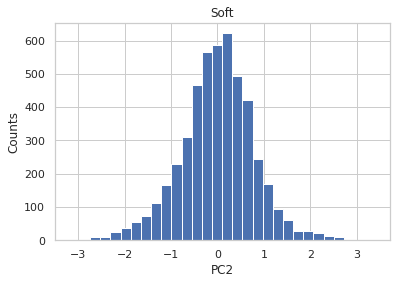

In [78]:
plt.hist(soft_pc2, density=False, bins=30)
plt.title('Soft')
plt.xlabel('PC2')
plt.ylabel('Counts')

plt.savefig('/content/figures/histograms/soft_pc2.eps')

##Cell boundary recreation from PCs

Using raw normalized boundary points to plot cell boundary shape

In [79]:
!mkdir figures/pc_cellshape

In [80]:
x=stiff_movies['controls_2019_062819_sample2_track6']['Boundary coordinates'][1][0:50]
y=stiff_movies['controls_2019_062819_sample2_track6']['Boundary coordinates'][1][50:]

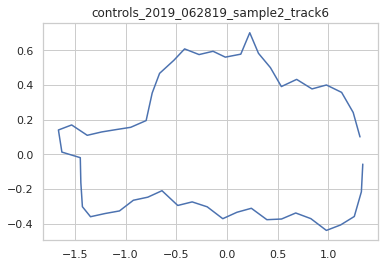

In [81]:
plt.plot(x,y)
plt.title('controls_2019_062819_sample2_track6')

plt.savefig('/content/figures/pc_cellshape/actual_boundary.eps')

Using PCA to get the raw boundary points back (multiplying score by transpose of eigenvectors and adding mean boundary points) using all the principal components

In [82]:
x_back=np.dot(stiff_movies['controls_2019_062819_sample2_track6']['Score from PCA'][1],eigenvecs.T)[0:50]+model['mdd'][0:50]
y_back=np.dot(stiff_movies['controls_2019_062819_sample2_track6']['Score from PCA'][1],eigenvecs.T)[50:]+model['mdd'][50:]

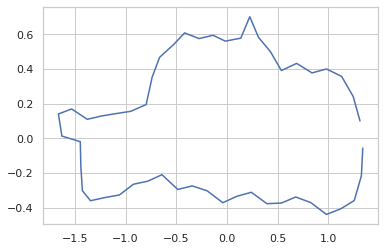

In [83]:
plt.plot(x_back,y_back)

Using first 10 principal components to reconstruct cell boundary shape

In [84]:
PC10_eigenvecs = []
for vec in eigenvecs:
  new_vec=vec[:10]
  PC10_eigenvecs.append(new_vec)
PC10_eigenvecs=np.array(PC10_eigenvecs)

In [85]:
x_10PC=np.dot(stiff_movies['controls_2019_062819_sample2_track6']['Score from PCA'][1][:10],PC10_eigenvecs.T)[0:50]+model['mdd'][0:50]
y_10PC=np.dot(stiff_movies['controls_2019_062819_sample2_track6']['Score from PCA'][1][:10],PC10_eigenvecs.T)[50:]+model['mdd'][50:]

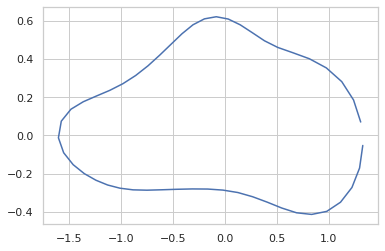

In [86]:
plt.plot(x_10PC,y_10PC)
plt.savefig('/content/figures/pc_cellshape/10PC_boundary.eps')

Using first 20 principal components to reconstruct cell boundary shape

In [87]:
PC20_eigenvecs = []
for vec in eigenvecs:
  new_vec=vec[:20]
  PC20_eigenvecs.append(new_vec)
PC20_eigenvecs=np.array(PC20_eigenvecs)

In [88]:
x_20PC=np.dot(stiff_movies['controls_2019_062819_sample2_track6']['Score from PCA'][1][:20],PC20_eigenvecs.T)[0:50]+model['mdd'][0:50]
y_20PC=np.dot(stiff_movies['controls_2019_062819_sample2_track6']['Score from PCA'][1][:20],PC20_eigenvecs.T)[50:]+model['mdd'][50:]

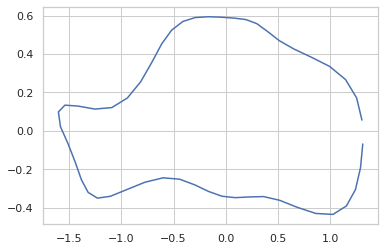

In [89]:
plt.plot(x_20PC,y_20PC)
plt.savefig('/content/figures/pc_cellshape/20PC_boundary.eps')

Artifically increase first principal component and see what happens

In [ ]:
weight = .9

In [ ]:
inc_PC20_eigenvecs = []
for vec in eigenvecs:
  new_vec=vec[:20]
  new_vec[0]+=weight
  inc_PC20_eigenvecs.append(new_vec)
inc_PC20_eigenvecs=np.array(inc_PC20_eigenvecs)

In [ ]:
inc_amt = np.zeros(20)
inc_amt[0]+=weight

In [ ]:
inc_pc1=list(stiff_movies['controls_2019_062819_sample2_track6']['Score from PCA'][1][:20] + inc_amt)

In [ ]:
x_inc = np.dot(inc_pc1,PC20_eigenvecs.T)[0:50]+model['mdd'][0:50]
y_inc = np.dot(inc_pc1,PC20_eigenvecs.T)[50:]+model['mdd'][50:]

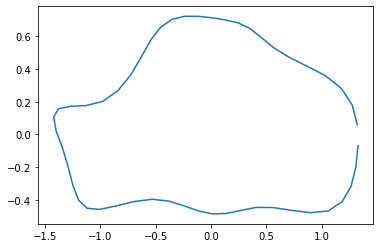

In [ ]:
plt.plot(x_inc,y_inc)

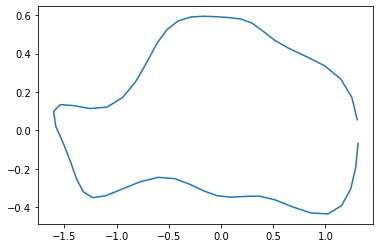

In [ ]:
plt.plot(x_20PC,y_20PC)

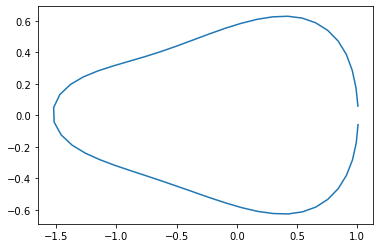

In [ ]:
#plot of averaged boundary points of all cells at all times
plt.plot(model['mdd'][0:50],model['mdd'][50:])

##Saving figures

In [92]:
!zip figures_11302021.zip -r figures

  adding: figures/ (stored 0%)
  adding: figures/histograms/ (stored 0%)
  adding: figures/histograms/grad2_pc2.eps (deflated 69%)
  adding: figures/histograms/grad1_pc2.eps (deflated 70%)
  adding: figures/histograms/grad1_pc1.eps (deflated 70%)
  adding: figures/histograms/grad2_pc1.eps (deflated 70%)
  adding: figures/histograms/soft_pc1.eps (deflated 71%)
  adding: figures/histograms/soft_pc2.eps (deflated 71%)
  adding: figures/histograms/stiff_pc2.eps (deflated 70%)
  adding: figures/histograms/stiff_pc1.eps (deflated 71%)
  adding: figures/grad2_pc1_overtime.eps (deflated 69%)
  adding: figures/pc3vspc2/ (stored 0%)
  adding: figures/pc3vspc2/stiff_absskew.eps (deflated 82%)
  adding: figures/pc3vspc2/soft_absskew.eps (deflated 79%)
  adding: figures/pc3vspc2/grad2_absskew.eps (deflated 81%)
  adding: figures/pc3vspc2/all_regions_absskew.eps (deflated 82%)
  adding: figures/pc3vspc2/grad1_absskew.eps (deflated 82%)
  adding: figures/pc3vspc2/all_regions.eps (deflated 62%)
  addi

In [93]:
!gsutil cp figures_11302021.zip gs://cellmbucket/VAMPIRE_analysis/all_controls/

Copying file://figures_11302021.zip [Content-Type=application/zip]...
/ [1 files][  2.8 MiB/  2.8 MiB]                                                
Operation completed over 1 objects/2.8 MiB.                                      
